In [23]:
import matplotlib.pyplot as plt
import numpy as np
import configs.pyroot_config as pyroot_config
import os
from torch.utils.data import default_collate
import torch
from src.data.mice_dataset import MouseSniffingVideoDatasetMultipleFramesLabeled
from src.data.mice_dataset_factory import create_dataset, trails_split
import torchvision.transforms.v2 as tt
from models.lightning_module import DeepSniff
from models.models import MobileNetV3
from pytorch_lightning.callbacks import *
import random


15000


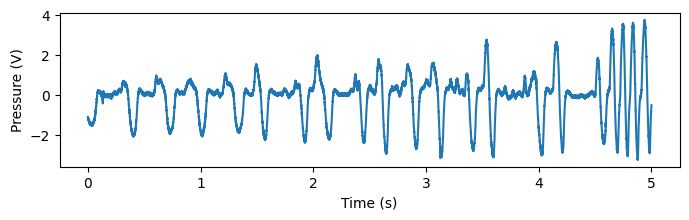

In [21]:
#load txt file at /scratch-local/users/markoc-haeslerlab/deepsniff-processed/Lausanne/004/signal.txt and plot


#load txt file
data = np.loadtxt('/scratch-local/users/markoc-haeslerlab/deepsniff-processed/Lausanne/004/signal.txt')
#45000 hz 3000
x = np.linspace(0, 15000/3000, 15000)
print(len(x))
#plot
#plt fig size
plt.figure(figsize=(8, 2))
plt.plot(x, data[:len(x)])
#x label time, seconds
#y label pressure
plt.xlabel('Time (s)')
plt.ylabel('Pressure (V)')
plt.show()

In [27]:

config_paths = pyroot_config.ConfigPaths()

### TRANSFORMS

loading_transforms=tt.Compose([tt.PILToTensor(),
                        tt.Grayscale(num_output_channels=1),
                        tt.Resize([112, 112] ,antialias=True)])
                        
transforms = tt.Compose([
                        tt.ConvertImageDtype(torch.float16),
                        tt.RandomHorizontalFlip(p=0.5),
                        tt.RandomRotation(degrees=20),
                        tt.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                        tt.Normalize(mean=[0.36], std=[0.2])])


transforms_val = tt.Compose([
                            tt.ConvertImageDtype(torch.float16),
                            tt.Normalize(mean=[0.36], std=[0.2])])

### DATASET

data_dir = config_paths.data_processed / 'sniff-training-dataset'

#list all subdirs
trails = [f.path for f in os.scandir(data_dir) if f.is_dir()]
#print(trails)

#train val test 0.9, 0.1, 0.1
trails = random.sample(trails, len(trails))
train_trails = trails[:int(0.8*len(trails))]
val_trails = trails[int(0.8*len(trails)):int(0.9*len(trails))]
test_trails = trails[int(0.9*len(trails)):]

#print len
print(len(train_trails), len(val_trails), len(test_trails))

#print trails
print('train:', train_trails)
print('val:', val_trails)
print('test:', test_trails)

window_size = 5         # Must be odd number
signal_window_size = 1  # Must be odd number

train_datasets = []
for trail in train_trails:
    train_datasets.append(MouseSniffingVideoDatasetMultipleFramesLabeled(root_dir='/scratch-local/users/markoc-haeslerlab/sniff-training-dataset/230221_LK031_4',
                                                                        video_path='cropped_frames',
                                                                        signal_path='breathing_onsets.txt',
                                                                        window_size=window_size,
                                                                        signal_window_size=signal_window_size,
                                                                        transforms=transforms,
                                                                        loading_transforms=loading_transforms,
                                                                        load_in_memory=False))
train_dataset = torch.utils.data.ConcatDataset(train_datasets)



32 4 4
train: ['data/processed/sniff-training-dataset/220820_ES022_6', 'data/processed/sniff-training-dataset/221130_RDP086_7', 'data/processed/sniff-training-dataset/230829_RDP105_6', 'data/processed/sniff-training-dataset/220610_KK021_9', 'data/processed/sniff-training-dataset/231218_LK062_4', 'data/processed/sniff-training-dataset/231010_KK063_1', 'data/processed/sniff-training-dataset/220727_LK013_4', 'data/processed/sniff-training-dataset/240405_RDP146_2', 'data/processed/sniff-training-dataset/221129_RDP086_6', 'data/processed/sniff-training-dataset/220223_RDP043_5', 'data/processed/sniff-training-dataset/220223_RDP043_3', 'data/processed/sniff-training-dataset/240418_RDP166_7', 'data/processed/sniff-training-dataset/230318_KK048_6', 'data/processed/sniff-training-dataset/230609_RDP105_5', 'data/processed/sniff-training-dataset/230825_RDP105_0', 'data/processed/sniff-training-dataset/221123_RDP086_1', 'data/processed/sniff-training-dataset/230829_RDP129_10', 'data/processed/sniff

In [ ]:
#load a sample from the dataset and plot the image

sample = train_dataset[0]